# Exercise 2
---

## Problem: 
1. Ask user to supply the mean and standard deviation of a 1D Gaussian
2. For the given mean and std, draw 1000 random samples from $[-2\sigma,+2\sigma]$ to build a datset $D$
3. Split the dataset into train ($90\%$) and test ($10\%$): $D = \{ D_{train},D_{test} \}$
4. Using pure **Python3** and **Numpy**, build a $3$-layer neural network:
$$\mathrm{Layers} : \{  1 - 64 - ReLU - 64 - ReLU - 64 - 1 - sigmoid \}$$
5. Initialize the weights using  a Gaussian distribution with $0$ mean and std of $1$
6. Using pure **Python3** and **Numpy**, implement the backpropagation. Learning rate = $0.1$; Batch size = $1$; Loss = $MSE$
7. Train for 20 epochs and evaluate performance of network

## Solution
---

Let us first declare our dependencies. We shall be using solely `Python 3` and `numpy` in implementing our neural network and its training. The `matplotlib` and `time` libraries are just to aid us in data visualization and to monitor the time it takes for our training later on.

In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import time

np.random.seed(14) # for reproducibility

## 1. Neural network definition

We first define our neural network. As stated above, we are to construct a 3-layer network that has layers $\{  1 - 64 - ReLU - 64 - ReLU - 64 - 1 - sigmoid \}$. One of the key ideas here is understanding each layer dimension. For instance, below is an image of a 3-layer neural network with the two hidden layers each of dimension ${\rm I\!R}^{8}$. For this exercise however, we just need to change the dimensions of our hidden layers to $64$ as the instructions of this activity suggests. Furthermore, it can be understood that the dimensions of our input and output layers are both ${\rm I\!R}^{1}$ for this activity. It is by practice that definition of an $n$-layer neural network is the number of hidden layers **and** the output layer. This certain configuration is known as a **multi-layered perceptron (MLP)**.

<p align="center">
<img src="./images/nn.png" alt="neural network" width="800"/>
</p>


Each layer has what we call **neurons** (also sometimes called as *perceptrons*). Taking inspiration from human biology, you can think of this as an abstract mathematical approximation of the biological neuron. Artificial intelligence may have just been a trending field in the recent years but *artificial neural networks* were actually first introduced back in 1943 in this [paper](https://link.springer.com/article/10.1007%2FBF02478259).

By definition, it's essentially a mathematical function that takes one or more inputs that are multiplied by values called *weights*. Visually this can be seen or represented by the lines connecting one neuron to another. At each layer there is also a *bias* that helps better fit the data. Together these make up what we call the **trainable parameters** or sometimes just **parameters**. Visually this can be seen or represnted by the lines that interconnects one neuron to another. In our specific architecture for example, it can be deduced that there's a total of $(1 \times 64 + 64 \times 64 + 64 \times 1) + (64 + 64 + 1) = \mathbf{4353}$ trainable parameters. This is simply the connections (or *weights*) between each layer plus the bias in every layer.



## 2. Network initilization

Before training, we first initialize our neural network. That is, we initialize or give assumed initial values to the **parameters** we just had defined previously. The task that we are expecting a neural network to do is converging to a minima using gradient descent. If initialization is done correctly, optimization will be achieved in the least time otherwise converging by gradient descent will be an impossible task. Initializing parameters is important for if they're to either too small or large, they tend to saturate and gradient falls to zero, that is, *the neural network won't learn*. Network initialization can almost be considered as a subfield in itself of machine learning. There are various initialization techniques out there such as Zero Initialization, Random Weights Initializations, Xavier Initialization, just to name a few. 

For this activity however, we are to initialize our parameters using the Gaussian distribution with $0$ mean and standard deviation of $1$. Doing this alone poses two possible issues though. Either we'd have **vanishing gradients** or **exploding gradients**. The former can simply be understood as the parameter update being very minimal that results to slower to no convergence at all. The latter is the exact opposite with the gradients being too large resulting to oscillating around the minima or even overshooting the optimum again and again. Either way, the network won't learn in these circumstances. One initialization technique we could use is called [He Initialization](https://arxiv.org/abs/1502.01852) introduced around 2015. This attempts to solve the gradients issues of initialization by multiplying the randomly generated values from the normal distribution by a scaling factor shown below. 

$$\sqrt{\frac{2}{\mathrm{size}^{[\mathrm{previous \ layer]}}}}$$ 

Note that setting biases to $0$ will not create any troubles as non-zero weights take care of breaking the symmetry and even if bias is $0$, the values in every neuron are still different.

In [2]:
def init_network(nn_architecture):
    
    number_of_layers = len(nn_architecture)
    params_values = {}
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        
        layer_input_size = layer["input_dim"] # input dimensions
        layer_output_size = layer["output_dim"] # output dimensions

        # weights initialization using He Initialization
        params_values['W' + str(layer_idx)] = np.random.normal(0, 1, size=(layer_output_size, layer_input_size)) * (np.sqrt(np.divide(2,layer_input_size)))
        
        # biases
        params_values['b' + str(layer_idx)] = np.zeros((layer_output_size,1))
        
    return params_values

## 3. Activation functions

Activation functions are associated with every layer in the neural network. Mathematically, these are simply either linear or non-linear functions. In neural networks, they accept the input and parameters as its argument. The output of a neuron is defined by the output of a chosen activation function.

The need for activation functions arises because our operations are pretty much just linear without it (i.e. multiplying weights and adding biases). **We don't want our model to perform in such manner because real world data is pretty much always non-linear.**

There are a lot of activation functions used in machine learning but for this activity, we shall only be using ReLU and Sigmoid activation functions.

### 3a) ReLU
$$\sigma_{ReLU}(x) = max(x,0)$$
<p align="center">
<img src="./images/relu.png" alt="relu" width="400"/>
</p>

### 3b) Sigmoid
$$\sigma_{sigmoid}(x) = \frac{1}{1 + e^{-x}}$$
<p align="center">
<img src="./images/sigmoid.png" alt="sigmoid" width="400"/>
</p>



In [3]:
def sigmoid(X):
    return 1/(1+np.exp(-X))

def relu(X):
    return np.maximum(0,X)

## 3. Loss function

A loss function (or sometimes called as *cost function* or *obnjective function*) is what tells the measure of success for the task at hand, in other words, this tells how our model performs during training. The goal is to minimize the *cost* or *loss* given by the loss function during training. There are different kinds of loss functions and choosing which is appropriate for the problem is important. For instance, for a two-class classification problem, binary crossentropy is usually used and categoral crossentropy for a many-class classification problem on the other hand. For this activity, we are going to use **Mean-Squared Error (MSE)** as our loss function.

$$ MSE =  \frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y_{i}})^2 $$

where, $n$ is the number of data points, $Y_i$ is the observed values/ground truth, and $\hat{Y_{i}}$ is the predicted values.

In [4]:
def loss_function(prediction, ground_truth):   
    m = np.mean(np.square(np.subtract(ground_truth,prediction)))
    return m

def l1_distance(prediction, ground_truth): 
    l1 = np.mean(np.abs(prediction - ground_truth))
    return l1

## 4. Forward Propagation

Forward propagation is how neural networks make predictions. The idea is very simple. Consider the equation below for better illustration.

$$\hat{y} = \sigma (W_{out} \cdot \sigma(W_hx + b_h)+b_{out})$$

Assume a simple a $2$-layer network, that is a single hidden layer and an output layer. Forward propagation can be understood in three simple steps.

1. The weighted input is calculated by multiplying the input $x$ with the hidden weight $W_h$
2. An activation function $\sigma(x)$ where $x$ is the weighted input gotten from above is applied before passing the result to the succeeding layer, in this case the output layer.
3. We repeat the previous step, but this time replacing $W_h$ with the $W_{out}$ (i.e., the succeeding layer's weight, in this case the output layer weight)

We simply repeat this process for multiple $n$-dimension layers. Note that since we are generally dealing with vectors the operation $W_nx$ is a dot product of $W_n$ and $x$.

In [5]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation):
    
    # y = f(Wx+b)
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    # you can add other activation functions here such as tanh, LeakyReLU, etc. 
    else:
        raise Exception('Undefined activation function')

    # we return the output of the activation function and the weighted input 
    return activation_func(Z_curr), Z_curr

In [6]:
def full_forward_propagation(X, params_values, nn_architecture):
    # we declare a temporary memory to store the values we'd eventually need for backpropagation
    memory = {}
    A_curr = X
    
    # iterate over network layers
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)] # current weights
        b_curr = params_values["b" + str(layer_idx)] # current biases
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr) # current weighted input and activation function output
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    return A_curr, memory

## 5. Backpropagation

Let's have a short recap of our understanding as of the moment. Going over forward propagation, we knew that this was a simple linear operation of having out input multiplied by a scaling factor called the weight then added by a certain bias.

$$z = wx + b$$

We then went through activation functions which defines the output of a certain node/layer.

$$\hat{y} = \sigma(z)$$

Afterwards, we had defined a cost function that serves as a measure of success of the task our neural network is trying to accomplish. 

$$L(y,\hat{y}) = \frac{1}{n} \sum_{i=1}^n (y_{i}-\hat{y_{i}})^2$$

The goal is to achieve the least cost or loss by the end of our training. This is achieved thru what we call *backpropagation*. Backpropagation is the *central algorithm* in deep learning. This is how the neural network basically *learns* by adjusting the weights and biases accordingly as guided by the goal of minimising the cost. The main concept here is using the chain rule of differentiation. Calculus tells us that a chain of functions can be derived using the chain rule defined as  $f(g(x)) = f'(g(x)) * g'(x)$. Backpropagation starts with the final loss value and works backward from the top layers to the bottom layers, applying the chain rule to compute the contribution that each parameter had in the loss value. To update the network, we calculate the so called *gradients*, which are small nudges (updates) to individual weights in each layer. 

$$\frac{\partial L}{\partial w}$$

<p align="center">
<img src="https://mlfromscratch.com/content/images/2019/12/overview-nn-optimized.gif" width="500"/>
</p>

In [7]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Undefined activation function')
    
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    dW_curr = np.dot(dZ_curr, np.transpose(A_prev))
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True)
    dA_prev = np.dot(np.transpose(W_curr), dZ_curr)
    
    return dA_prev, dW_curr, db_curr

In [8]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
            
    dA_prev = 2 * (Y_hat-Y)
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

The derivative of our loss with respect to the weights however can't directly be solved. This is were *chain rule* comes in. We can express the equation above by,

$$\frac{\partial L}{\partial w} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z} \cdot \frac{\partial z}{\partial w}$$

and then we do the same for the biases.

In [9]:
# derivative of activation functions that will be used in the chain rule in backpropagation

def sigmoid_backward(dA, x):
    sig = sigmoid(x)
    dL = dA * sig * (1 - sig)
    return dL

def relu_backward(dA, x):
    dL = np.array(dA, copy = True)
    dL[x <= 0] = 0;
    return dL

We then update our weights and biases as shown below.

$$ w_{updated} = w_{current} - \mathrm{learning\ rate} \times \frac{\partial C}{\partial w_{current}} $$

Notice that we introduced something called *learning rate*. This can intuitively be understood as a scaling factor that dictates the magnitude of our move/adjustment of the weight update. This is a hyperparameter that can be tuned in several ways. For instance, there is something called *learning rate schedule*. Most common of which are time-based, step-based, and exponential.

In [10]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values

## 6. Training

Finally, putting everything together we define our training function. A good visualization of our training is shown below.

<p align="center"> 
<img src="./images/train.png" alt="train" width="400"/>
</p>

In [11]:
def train(X, Y, nn_architecture, epochs, learning_rate):
        
    params_values = init_network(nn_architecture)
    
    # performing calculations for subsequent iterations
    cost_history = []
    l1_history = []

    for epoch in range(epochs):
        # print(epoch)
        
        for i in range(len(X)):
            start_time = time.time()
            # step forward
            Y_hat, cache = full_forward_propagation(X[i].reshape(1,1), params_values, nn_architecture)
            
            # calculating metrics and saving them in history
            cost = loss_function(Y_hat, Y[i])
            l1 = l1_distance(Y_hat, Y[i])

            grads_values = full_backward_propagation(Y_hat, Y[i], cache, params_values, nn_architecture)
            params_values = update(params_values, grads_values, nn_architecture, learning_rate)

        cost_history.append(np.mean(cost))
        l1_history.append(np.mean(l1))
        print("Epoch: {:02d} \t===\t Loss: {:.5f} \t===\t L1: {:.5f} \t===\t Time elapsed: {:.5f}s".expandtabs(4).format(epoch+1, np.mean(cost), np.mean(l1), time.time() - start_time))

    return params_values, cost_history, l1_history

### 6a) Neural Network Architecture

In [12]:
mlp = [
    {"input_dim": 1, "output_dim": 64, "activation": "relu"},
    {"input_dim": 64, "output_dim": 64, "activation": "relu"},
    {"input_dim": 64, "output_dim": 1, "activation": "sigmoid"},
]

### 6b) Dataset Generation

In [13]:
# user defined
mu = float(input('Enter mean:'))
sigma = float(input('Enter standard deviation:'))

s = np.random.normal(mu, sigma, 1000000)

s1 = np.array(list(filter(lambda x: x <= (mu + 2*sigma) and x >= (mu - 2*sigma), s)))

dataset_len = 1000
TRAIN_SPLIT = int(0.9 * dataset_len)
TEST_SPLIT = int(0.1 * dataset_len)

dataset_x = np.random.choice(s1, dataset_len)
# gaussian distribution function as ground truth for training
dataset_y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (dataset_x - mu)**2 / (2 * sigma**2) )

train_x, test_x = np.split(dataset_x, [TRAIN_SPLIT])
train_y, test_y = np.split(dataset_y, [TRAIN_SPLIT])

### 6c) Training proper

In [14]:
loss = []
l1 = []

epochs = 20
learning_rate = 0.1

params_values, loss, l1 = train(np.transpose(train_x), np.transpose(train_y), mlp, epochs=epochs, learning_rate=learning_rate)

Epoch: 01   ===  Loss: 0.17865   ===  L1: 0.42267     ===  Time elapsed: 0.00016s
Epoch: 02   ===  Loss: 0.17865   ===  L1: 0.42267     ===  Time elapsed: 0.00015s
Epoch: 03   ===  Loss: 0.00770   ===  L1: 0.08772     ===  Time elapsed: 0.00015s
Epoch: 04   ===  Loss: 0.00136   ===  L1: 0.03689     ===  Time elapsed: 0.00015s
Epoch: 05   ===  Loss: 0.00141   ===  L1: 0.03752     ===  Time elapsed: 0.00015s
Epoch: 06   ===  Loss: 0.00148   ===  L1: 0.03849     ===  Time elapsed: 0.00014s
Epoch: 07   ===  Loss: 0.00153   ===  L1: 0.03906     ===  Time elapsed: 0.00015s
Epoch: 08   ===  Loss: 0.00162   ===  L1: 0.04019     ===  Time elapsed: 0.00014s
Epoch: 09   ===  Loss: 0.00184   ===  L1: 0.04285     ===  Time elapsed: 0.00015s
Epoch: 10   ===  Loss: 0.00204   ===  L1: 0.04516     ===  Time elapsed: 0.00015s
Epoch: 11   ===  Loss: 0.00250   ===  L1: 0.04998     ===  Time elapsed: 0.00015s
Epoch: 12   ===  Loss: 0.01042   ===  L1: 0.10210     ===  Time elapsed: 0.00014s
Epoch: 13   === 

## 7. Evaluation

From the dataset preparation we made earlier, we apply a forward propagation to the **test dataset**. That is the remaining $10\%$ unseen samples from the dataset we generated.

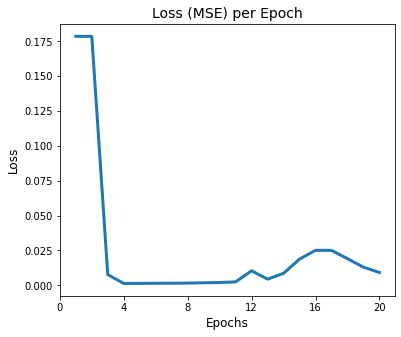

In [15]:
loss = np.array(loss)
epoch = np.array(range(1,epochs+1,1))
plt.figure(figsize=(6,5))
plt.plot(epoch,loss, linewidth="3")
plt.title('Loss (MSE) per Epoch',  fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(range(0,epochs+1,4))
plt.show()

To illustrate one scenario, this is for a mean of $2$ and standard deviation of $0.75$. Observe that at the beginning of the training, the loss is so high and and it gradually decreased throughout the training. With a simple 3-layer neural network of just 20 epochs of training, we can see below how the neural network predicts the model of a Gaussian distribution.

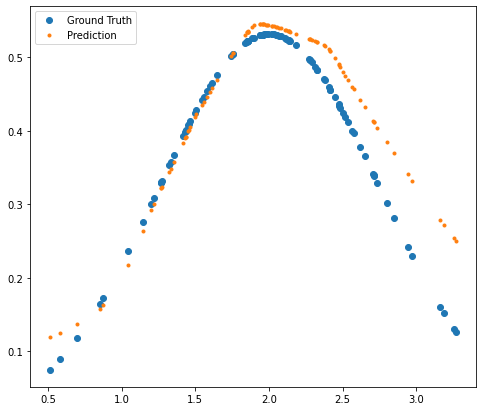

In [16]:
test_y_hat, _ = full_forward_propagation(np.transpose(test_x.reshape(-1,1)), params_values, mlp)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,7))
plt.plot(test_x, test_y, 'o', label='Ground Truth')
plt.plot(test_x, np.transpose(test_y_hat), '.', label='Prediction')
plt.legend(loc='upper left')
plt.show()

## 8. What if we can train on a relatively more complex network with higher epochs?

For the sake of demonstration and illustration on how training parameters and network architecture contributes to our performance, consider the an 8-layer network below trained on $20$ epochs.

Epoch: 01   ===  Loss: 0.00637   ===  L1: 0.07984     ===  Time elapsed: 0.00025s
Epoch: 02   ===  Loss: 0.00618   ===  L1: 0.07862     ===  Time elapsed: 0.00024s
Epoch: 03   ===  Loss: 0.00565   ===  L1: 0.07517     ===  Time elapsed: 0.00024s
Epoch: 04   ===  Loss: 0.00633   ===  L1: 0.07954     ===  Time elapsed: 0.00025s
Epoch: 05   ===  Loss: 0.00341   ===  L1: 0.05839     ===  Time elapsed: 0.00028s
Epoch: 06   ===  Loss: 0.00006   ===  L1: 0.00756     ===  Time elapsed: 0.00024s
Epoch: 07   ===  Loss: 0.00005   ===  L1: 0.00685     ===  Time elapsed: 0.00024s
Epoch: 08   ===  Loss: 0.00000   ===  L1: 0.00151     ===  Time elapsed: 0.00025s
Epoch: 09   ===  Loss: 0.00002   ===  L1: 0.00448     ===  Time elapsed: 0.00025s
Epoch: 10   ===  Loss: 0.00010   ===  L1: 0.01009     ===  Time elapsed: 0.00024s
Epoch: 11   ===  Loss: 0.00001   ===  L1: 0.00337     ===  Time elapsed: 0.00025s
Epoch: 12   ===  Loss: 0.00000   ===  L1: 0.00037     ===  Time elapsed: 0.00024s
Epoch: 13   === 

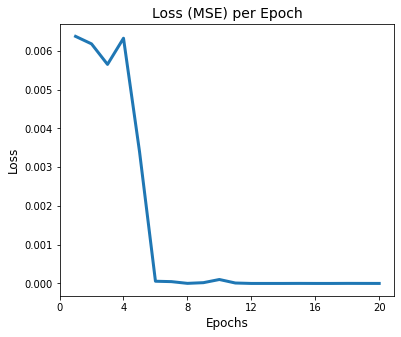

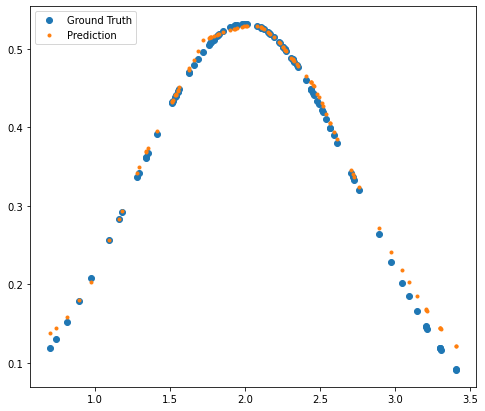

In [17]:
mlp = [
    {"input_dim": 1, "output_dim": 64, "activation": "relu"},
    {"input_dim": 64, "output_dim": 64, "activation": "relu"},
    {"input_dim": 64, "output_dim": 64, "activation": "relu"},
    {"input_dim": 64, "output_dim": 64, "activation": "relu"},
    {"input_dim": 64, "output_dim": 64, "activation": "relu"},
    {"input_dim": 64, "output_dim": 1, "activation": "sigmoid"},
]

# user defined
mu = float(input('Enter mean:'))
sigma = float(input('Enter standard deviation:'))

s = np.random.normal(mu, sigma, 1000000)

s1 = np.array(list(filter(lambda x: x <= (mu + 2*sigma) and x >= (mu - 2*sigma), s)))

dataset_len = 1000
TRAIN_SPLIT = int(0.9 * dataset_len)
TEST_SPLIT = int(0.1 * dataset_len)

dataset_x = np.random.choice(s1, dataset_len)
# gaussian distribution function as ground truth for training
dataset_y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (dataset_x - mu)**2 / (2 * sigma**2) )

train_x, test_x = np.split(dataset_x, [TRAIN_SPLIT])
train_y, test_y = np.split(dataset_y, [TRAIN_SPLIT])

loss = []
l1 = []

epochs = 20
learning_rate = 0.1

params_values, loss, l1 = train(np.transpose(train_x), np.transpose(train_y), mlp, epochs=epochs, learning_rate=learning_rate)

loss = np.array(loss)
epoch = np.array(range(1,epochs+1,1))
plt.figure(figsize=(6,5))
plt.plot(epoch,loss, linewidth="3")
plt.title('Loss (MSE) per Epoch',  fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(range(0,epochs+1,4))
plt.show()

test_y_hat, _ = full_forward_propagation(np.transpose(test_x.reshape(-1,1)), params_values, mlp)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,7))
plt.plot(test_x, test_y, 'o', label='Ground Truth')
plt.plot(test_x, np.transpose(test_y_hat), '.', label='Prediction')
plt.legend(loc='upper left')
plt.show()

Notice how there is visble improvement from our intial 3-layer network model. This stems for the reasoning that we have more trainable parameters in this scenario as we have exaplined in the first section of this noteboook. 

## References

- <https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/01_mysteries_of_neural_networks/03_numpy_neural_net/Numpy%20deep%20neural%20network.ipynb>
- <https://www.sciencedirect.com/topics/chemical-engineering/neural-network>
- <https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78>
- <https://www.kdnuggets.com/2018/06/deep-learning-best-practices-weight-initialization.html>
- <https://ml-cheatsheet.readthedocs.io/>
- <https://mlfromscratch.com/neural-networks-explained>
